#Labeling an unseen corpus
##Part 0, everything mixed


Lets preparethe necessary data

[link](#shortcut "intra link")

[Wikipedia](https://en.wikipedia.org/wiki/Main_Page "But what is wikipedia?")

Bunch of imports

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function

# import local library
import tools
import prepare
import lemmatize
import analyze
import preprocess
import nnlstm

##Exctract the MedLine data

In [2]:
data = prepare.extract_txt('OLD/data_old/reduced_10000.txt')

Exctracting from 'reduced_10000'...
224 documents exctracted - 1.9KB  [298.1KB/s]
Done. [0.01s]


##Isolate the abstracts

In [3]:
abstracts = prepare.get_abstracts(data)

Working on 4 core...
1.4KB/s on each of the [4] core
Done. [0.34s]


Cleaning, dumping the abstracts with errors, quick and dirty

In [4]:
def remove_err(datas,errs):
    err=sorted([item for subitem in errs for item in subitem],reverse=True)
    for e in err:
        for d in datas:
            del d[e]

In [5]:
remove_err([abstracts],prepare.get_errors(abstracts))

Replacing numbers with ##NB

In [6]:
abstracts = prepare.filter_numbers(abstracts)

Filtering numbers...
Done. [0.04s]


Creation of a tokenizer for a correct sentence splitting

In [7]:
tokenizer = prepare.create_sentence_tokenizer(abstracts)

Loading sentence tokenizer...
Done. [0.12s]


In [8]:
abstracts_labeled = prepare.ex_all_labels(abstracts,tokenizer)

Working on 4 core...
1.3KB/s on each of the [4] core
Done. [0.39s]


##Lemmatization and special imports

In [9]:
lemmatized = lemmatize.lemm(abstracts_labeled)

Working on 4 core...
Splitting datas... Done. [0.01s]
Lemmatizing...
Done. in 14s]


In [25]:
tools.dump_pickle(lemmatized,"fast_lemmatized.pickle")

File already exist. Overwrite? [Y/N]
>Y
Dumping...
Done. [0.05s]


In [26]:
lemmatized = tools.load_pickle("fast_lemmatized.pickle")

Loading 'fast_lemmatized.pickle'...
Done. [0.03s]


###Label analysis
*Does not affect the corpus*

In [27]:
dic = analyze.create_dic_simple(lemmatized)

Copying corpus...Done. [0.01s]
Creating dictionary of labels...
Done. [0.00s]


In [28]:
print("Number of labels :",len(dic.keys()))
analyze.show_keys(dic,threshold=10)

Number of labels : 58
195______RESULTS
151______METHODS
146______BACKGROUND
117______CONCLUSIONS
91_______CONCLUSION
26_______INTRODUCTION
22_______OBJECTIVE
16_______MATERIALS AND METHODS
10_______OBJECTIVES
10_______PURPOSE
...
(48 other labels with less than 10 occurences)
...


In [29]:
primary_keyword=['AIM','BACKGROUND','METHOD','RESULT','CONCLUSION','OBJECTIVE','DESIGN','FINDINGS','OUTCOME','PURPOSE']

In [30]:
analyze.regroup_keys(dic,primary_keyword)

Keys regrouped: 30


In [31]:
analyze.show_keys(dic,threshold=10)

212______CONCLUSION
200______RESULT
192______METHOD
149______BACKGROUND
33_______OBJECTIVE
26_______INTRODUCTION
10_______PURPOSE
...
(22 other labels with less than 10 occurences)
...


In [32]:
keys_to_replace = [['INTRODUCTION'],
                   ['AIM','PURPOSE'],
                   ['CONTEXT']]

replace_with =    ['BACKGROUND',
                   'OBJECTIVE',
                   'BACKGROUND']

In [33]:
analyze.replace_keys(dic,keys_to_replace,replace_with)

Keys regplaced: 4


In [34]:
analyze.show_keys(dic,threshold=10)

212______CONCLUSION
200______RESULT
192______METHOD
176______BACKGROUND
52_______OBJECTIVE
...
(20 other labels with less than 10 occurences)
...


###Choosing labels

In [35]:
pattern = [
    ['BACKGROUND','BACKGROUNDS'],
    ['METHOD','METHODS'],
    ['RESULT','RESULTS'],
    ['CONCLUSION','CONCLUSIONS']
]

In [36]:
sub_perfect = analyze.get_exactly(lemmatized,pattern=pattern,no_truncate=False)

Selecting abstracts...
98/219 match the pattern (44%)
Done. [0.00s]


In [37]:
print("%d abstracts labeled and ready for the next part!"%len(sub_perfect))

98 abstracts labeled and ready for the next part!


##Preparing the data for the classifier

In [38]:
dic = preprocess.create_dic(sub_perfect,100)

Copying corpus...Done. [0.01s]
Creating dictionary of labels...
Done. [0.00s]


In [39]:
primary_keyword=['AIM','BACKGROUND','METHOD','RESULT','CONCLUSION','OBJECTIVE','DESIGN','FINDINGS','OUTCOME','PURPOSE']
analyze.regroup_keys(dic,primary_keyword)

Keys regrouped: 3


In [40]:
keys_to_replace = [['INTRODUCTION','OBJECTIVE'],
                   ['AIM','PURPOSE'],
                   ['CONTEXT']]

replace_with =    ['BACKGROUND',
                   'OBJECTIVE',
                   'BACKGROUND']

analyze.replace_keys(dic,keys_to_replace,replace_with)

Keys regplaced: 0


In [41]:
print("Sentences per label :",["%s %d"%(s,len(dic[s][1])) for s in dic.keys()])

Sentences per label : ['RESULT 447', u'BACKGROUND 260', u'METHOD 284', u'CONCLUSION 198']


###Creating train and test data

In [42]:
# classes to use a classifier onto
#classes_names=['BACKGROUND','METHOD','RESULT','CONCLUSION']
classes_names = dic.keys()
dic.keys()

['RESULT', u'BACKGROUND', u'METHOD', u'CONCLUSION']

In [43]:
classes_names = [u'BACKGROUND', u'METHOD', u'RESULT', u'CONCLUSION']

In [44]:
# train/test split
split = 0.8

# truncate the number of abstracts to consider for each label,
# -1 to set to the maximum while keeping the number of sentences per labels equal
truncate = -1

raw_x_train, raw_y_train, raw_x_test, raw_y_test = preprocess.split_data(dic,classes_names,
                                                              split_train_test=split,
                                                              truncate=-1)

Vectorizing

In [45]:
X_train, y_train, X_test, y_test, feature_names, max_features, vectorizer = preprocess.vectorize_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)

Vectorizing the training set...Done. [0.04s]
Getting features...Done. [0.00s]
Creating order...Done. [0.02s]
Done. [0.06s]


##Training a neural network

imports

Adapt the data for a LSTM network

In [46]:
X_train, X_test, y_train, y_test = nnlstm.pad_sequence(X_train, X_test, y_train, y_test)

Pading sequences...
X_train shape: (633, 40)
X_test shape: (159, 40)
Done. [0.01s]


<a id='shortcut'></a>
shortcut

In [47]:
#X_train, y_train, X_test, y_test, feature_names, max_features, classes_names, vectorizer = tools.load_pickle("data/XyXyfmcv.pickle")

Creating the network

In [48]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

**Need approximatly a minute to construct the network**

In [49]:
%%time
dim_out = len(classes_names)

net = Sequential()
net.add(Embedding(max_features, 256))
net.add(LSTM(256, 256))
net.add(Dropout(0.5))
net.add(Dense(256, dim_out))
net.add(Activation('softmax'))
net.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

CPU times: user 49.7 s, sys: 692 ms, total: 50.4 s
Wall time: 50.7 s


/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


###Training the network

In [50]:
batch_size=16
length_train = 1000
length_test = 500
history = nnlstm.train_network(net,
                          X_train[:length_train],y_train[:length_train],X_test[:length_test],y_test[:length_test],
                          10,
                          batch_size=batch_size,path_save="weights",patience=2)

Training...
Train on 633 samples, validate on 159 samples
Epoch 0
633/633 [==============================] - 10s - loss: 1.3515 - acc: 0.3191 - val_loss: 1.3171 - val_acc: 0.3648
Saving at first epoch
Epoch 1
633/633 [==============================] - 10s - loss: 1.0243 - acc: 0.5924 - val_loss: 0.9762 - val_acc: 0.5723
Model improved, saving weight
Epoch 2
633/633 [==============================] - 10s - loss: 0.4083 - acc: 0.8863 - val_loss: 0.7261 - val_acc: 0.7233
Model improved, saving weight
Epoch 3
633/633 [==============================] - 10s - loss: 0.1744 - acc: 0.9573 - val_loss: 0.8260 - val_acc: 0.7170
Epoch 4
633/633 [==============================] - 10s - loss: 0.1164 - acc: 0.9700 - val_loss: 0.5327 - val_acc: 0.8113
Model improved, saving weight
Epoch 5
633/633 [==============================] - 11s - loss: 0.0695 - acc: 0.9842 - val_loss: 0.5565 - val_acc: 0.8302
Model improved, saving weight
Epoch 6
633/633 [==============================] - 10s - loss: 0.0468 - ac

In [51]:
net.load_weights("weights/best.hdf5")

##Evaluate the network

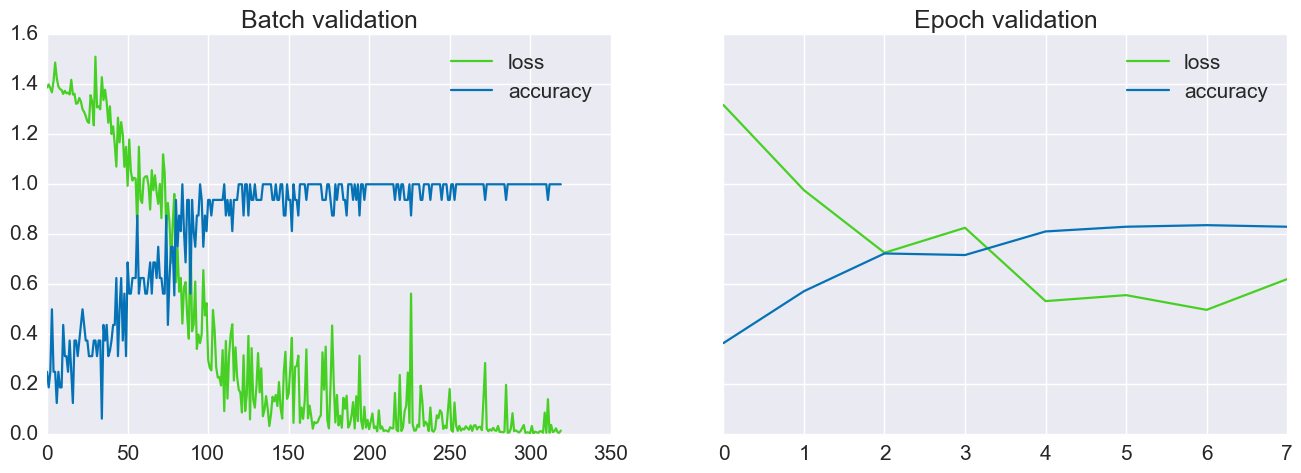

In [52]:
nnlstm.show_history(history)

No decision: 0 / 159  [0.00%]0 0
Accuracy: 0.907233
             precision    recall  f1-score   support

 BACKGROUND       0.97      0.88      0.93        43
     METHOD       0.76      0.82      0.79        34
     RESULT       0.69      0.77      0.73        31
 CONCLUSION       0.90      0.84      0.87        51

avg / total       0.85      0.84      0.84       159

Confusion matrix:
[[38  5  0  0]
 [ 1 28  4  1]
 [ 0  3 24  4]
 [ 0  1  7 43]]


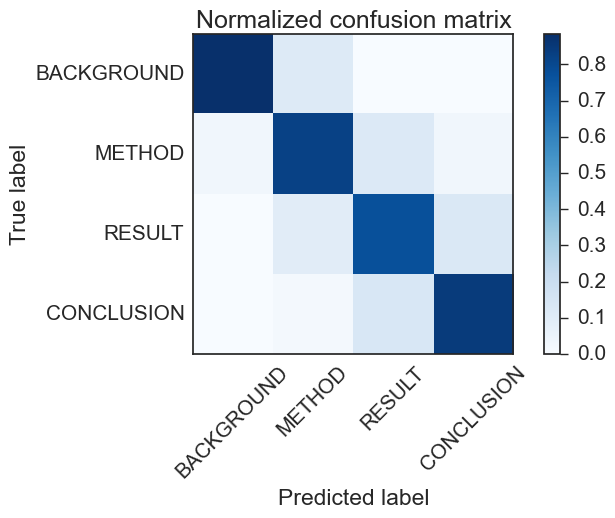

In [53]:
nnlstm.evaluate_network(net, X_test, y_test, classes_names, length=length_test)

##Predict on a new corpus

In [61]:
predictor = nnlstm.LSTMPredictor(net,vectorizer,classes_names,len_graph=20)

In [62]:
import codecs
import re
def oold(s):
    fname="./OLD/data_old/oth_lab/%s"%s
    s=codecs.open(fname, 'r','utf-8')
    txt = s.read()
    return re.sub(r'[ ]{2,}',' ',re.sub(r'[\n\t]+',' ',txt))
def ood(s):
    fname="./OLD/data_old/oth/%s"%s
    s=codecs.open(fname, 'r','utf-8')
    txt = s.read()
    return re.sub(r'[ ]{2,}',' ',re.sub(r'[\n\t]+',' ',txt))

In [63]:
tokenizer = tools.load_pickle("data/tokenizer.pickle")

Loading 'data/tokenizer.pickle'...
Done. [0.12s]


In [64]:
tools.show_colors(classes_names)

BACKGROUND      METHOD          RESULT          CONCLUSION      
BACKGROUND      METHOD          RESULT          CONCLUSION      

In [80]:
out = nnlstm.get_oth_lab(oold("d10"),tokenizer)

In [81]:
predictor.predict_labeled(out)

As a software component for computer game, the physics engine simulates objects' movement according to the laws of physics.

BACKGROUND |0.812|**************** [true label][predicted label]
METHOD     |0.044|*
RESULT     |0.008|
CONCLUSION |0.135|***
________________________________________________________________________________

This paper introduces a design and implementation of mobile game on the Android platform, where we used JBox2D physics engine library and Android graphics APIs.

BACKGROUND |0.985|******************** [true label][predicted label]
METHOD     |0.008|
RESULT     |0.001|
CONCLUSION |0.006|
________________________________________________________________________________

We borrowed the key idea of this game from Crayon Physics which is known as a famous PC game. 

BACKGROUND |0.509|********** [true label][predicted label]
METHOD     |0.198|****
RESULT     |0.069|*
CONCLUSION |0.224|****
____________________________________________________________________________